<a href="https://colab.research.google.com/github/AidinNiaparast/Classification-with-Logistic-Regression/blob/main/Variance_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Data

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("/content/sample_data/mnist_train_small.csv", delimiter=",")
test_data = np.loadtxt("/content/sample_data/mnist_test.csv", delimiter=",") 


#mapping data values to interval [0.01, 1]

fac = 0.99 / 255
train_data[:,1:] = train_data[:,1:]*fac + 0.01
test_data[:,1:] = test_data[:,1:]*fac + 0.01


data = train_data
np.random.shuffle(data)
data = data[0:6000]

Defining class SGD


In [ ]:
import torch
import random
import time

cross_entropy_loss = torch.nn.CrossEntropyLoss()

class SGD:
  def __init__(self, train_data, test_data, batch_size, n_iters):
    self.M = 6000
    self.gamma = 0.0001
    self.train_data = train_data
    self.test_data = test_data
    self.batch_size = batch_size
    self.n_iters = n_iters

    self.total_loss_list = []
    self.accuracy_list = []
    self.variance_list = []

  def loss(self, W, b, X, y):
    y_hat = torch.matmul(X,W) + b   #without softmax
    y = y.reshape(self.batch_size)
    loss = cross_entropy_loss(y_hat, y) + 0.5 * self.gamma * (torch.trace(torch.matmul(W.T, W)) + torch.matmul(b, b.T))
    return loss

  def total_loss(self,W,b):
    X = (self.train_data[:, 1:]).clone().detach()
    y = (self.train_data[:, [0]]).to(dtype = torch.long).clone().detach()
    y = y.reshape(self.M)
    y_hat = torch.matmul(X,W) + b   #without softmax
    loss = cross_entropy_loss(y_hat, y) + 0.5 * self.gamma * (torch.trace(torch.matmul(W.T, W)) + torch.matmul(b, b.T))
    return loss.item()  # retruns a number

  def accuracy(self, W, b):
    n = self.test_data.shape[0]
    X = self.test_data[:,1:]
    y = self.test_data[:,[0]]
    y = y.reshape(n)
    Z = torch.matmul(X,W) + b
    m = torch.nn.Softmax(dim=1)
    y_hat = m(Z)
    max_indices = torch.argmax(y_hat, dim=1)

    return torch.sum((max_indices==y)).long().item() / n    

  def variance(self, W_temp, b_temp):
    return (torch.sum(torch.var(W_temp, dim=0)) + torch.sum(torch.var(b_temp, dim = 0))).item()

  def run(self, learning_rate, evaluation_interval):
    self.total_loss_list = []
    self.accuracy_list = []
    self.variance_list = []

    print("Executing for Lambda=", learning_rate , '...')

    W = torch.zeros((28*28, 10)).double().clone().detach().requires_grad_(True)
    b = torch.zeros((1,10)).double().clone().detach().requires_grad_(True)

    for s in range(self.n_iters):
      W_temp = torch.zeros((evaluation_interval, 28*28, 10)).double().clone().detach()
      b_temp = torch.zeros((evaluation_interval, 1,10)).double().clone().detach()
      start_time = time.time()
      for t in range(evaluation_interval):
        sample = random.sample(range(0, self.M), self.batch_size)
        X = (self.train_data[sample, 1:]).clone().detach()
        y = (self.train_data[sample, [0]]).to(dtype = torch.long).clone().detach()
        
        l = self.loss(W,b,X,y)
        l.backward()

        with torch.no_grad():
          W -= learning_rate * W.grad
          b -= learning_rate * b.grad
          W_temp[t , : , :] = learning_rate * W.grad
          b_temp[t , : , :] = learning_rate * b.grad       

        W.grad.zero_()
        b.grad.zero_()
      
      total_loss = self.total_loss(W,b)
      accuracy = self.accuracy(W,b)
      variance = self.variance(W_temp, b_temp)
      self.total_loss_list.append(total_loss)
      self.accuracy_list.append(accuracy)
      self.variance_list.append(variance)
      
      if s%10 == 0:
        print("Step " , s+1 , " -> " , "   total loss=" , total_loss ,
              "    accuracy=" , accuracy, "    variance=" , variance, "   Time=" , time.time()-start_time)
    
    print("Execution finished for Lambda=", learning_rate)
    return self.total_loss_list, self.accuracy_list, self.variance_list

Results for part 1 (Raw SGD)

Executing for Lambda= 0.01 ...
Step  1  ->     total loss= 0.38407325800724973     accuracy= 0.885     variance= 0.002119888700927091    Time= 3.5111546516418457
Step  11  ->     total loss= 0.230861988417636     accuracy= 0.9055     variance= 0.0008334539284591537    Time= 3.5307536125183105
Step  21  ->     total loss= 0.18836923617091036     accuracy= 0.908     variance= 0.0006707633445550065    Time= 3.4588096141815186
Step  31  ->     total loss= 0.1761583918064651     accuracy= 0.9058     variance= 0.0005922939072186518    Time= 3.5134687423706055
Step  41  ->     total loss= 0.16707848416201734     accuracy= 0.9028     variance= 0.000514223420362875    Time= 3.4518682956695557
Step  51  ->     total loss= 0.1606934059952178     accuracy= 0.9019     variance= 0.0004888265266647471    Time= 3.476407289505005
Step  61  ->     total loss= 0.1576249973157384     accuracy= 0.8992     variance= 0.0004657068450781219    Time= 3.424680233001709
Step  71  ->     total loss= 0.150661339982

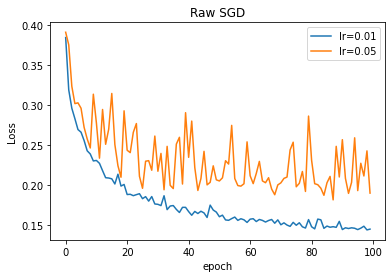

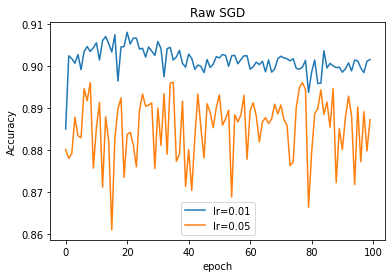

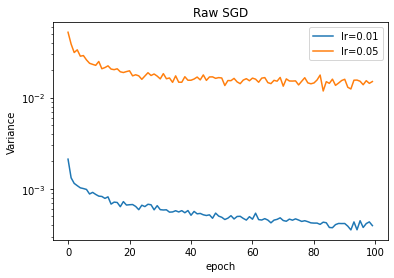

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()

M = 6000
n_iters = 100

labels = ['Loss', 'Accuracy', 'Variance']
Lambdas = [0.01, 0.05]
results = np.empty((2,3,n_iters))

obj = SGD(torch.tensor(data), torch.tensor(test_data), 1, n_iters)

evaluation_interval = M

for i in range(2):
  results[i] = obj.run(Lambdas[i], evaluation_interval)

raw_SGD_results1 = results[0,:,:]
raw_SGD_results2 = results[1,:,:]


print("Execution Time = " , time.time() - start_time)


for i in range(3):
  plt.title("Raw SGD")
  plt.ylabel(labels[i])
  plt.xlabel('epoch')

  if labels[i] == 'Variance':
    plt.yscale('log')

  for j in range(2):
    plt.plot(results[j][i] , label = 'lr=' + str(Lambdas[j]))
  plt.legend()
  plt.show()  


Results for part 2 (Batch SGD)

Executing for Lambda= 0.01 ...
Step  1  ->     total loss= 0.5305241585193924     accuracy= 0.8742     variance= 0.000766144593635629    Time= 0.9091098308563232
Step  11  ->     total loss= 0.2878886132413353     accuracy= 0.9067     variance= 0.0002858495822490104    Time= 0.896324872970581
Step  21  ->     total loss= 0.24874963542234885     accuracy= 0.9096     variance= 0.00022363722083211808    Time= 0.9005410671234131
Step  31  ->     total loss= 0.2287435601482329     accuracy= 0.9092     variance= 0.00021050023385820862    Time= 0.9145524501800537
Step  41  ->     total loss= 0.21476746732033816     accuracy= 0.9089     variance= 0.00018591708713715452    Time= 0.9130110740661621
Step  51  ->     total loss= 0.2063521498863019     accuracy= 0.907     variance= 0.00018589123081180062    Time= 0.9146904945373535
Step  61  ->     total loss= 0.19805286738203573     accuracy= 0.907     variance= 0.00016580325096216274    Time= 0.8921446800231934
Step  71  ->     total loss= 0.1885

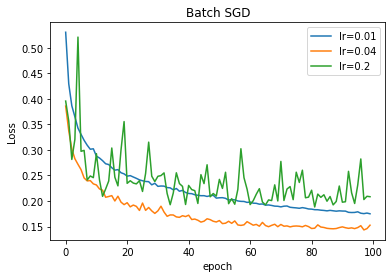

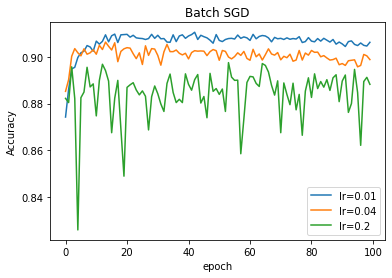

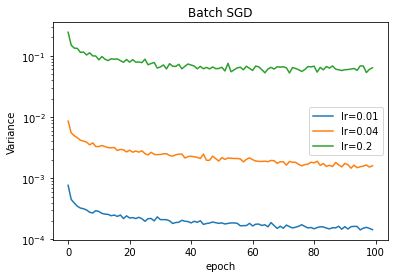

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()

M = 6000
n_iters = 100

labels = ['Loss', 'Accuracy', 'Variance']
Lambdas = [0.01, 0.04, 0.2]
results = np.empty((3,3,n_iters))

obj = SGD(torch.tensor(data), torch.tensor(test_data), 4, n_iters)

evaluation_interval = (int)(M/4)

for i in range(3):
  results[i] = obj.run(Lambdas[i], evaluation_interval)

batch_SGD_results1 = results[0,:,:]
batch_SGD_results2 = obj.run(0.05, evaluation_interval)    #this is for comparison in the last part

print("Execution Time = " , time.time() - start_time)


for i in range(3):
  plt.title("Batch SGD")
  plt.ylabel(labels[i])
  plt.xlabel('epoch')

  if labels[i] == 'Variance':
    plt.yscale('log')

  for j in range(3):
    plt.plot(results[j][i] , label = 'lr=' + str(Lambdas[j]))
  plt.legend()
  plt.show()  


Defining class SVRG

In [ ]:
import torch
import random
import time

cross_entropy_loss = torch.nn.CrossEntropyLoss()

class SVRG:
  def __init__(self, train_data, test_data, m, n_iters):
    self.M = 6000  #size of training_data
    self.m = 6000  #num of inner loop iterations
    self.n_iters = n_iters
    self.gamma = 0.0001
    self.train_data = train_data
    self.test_data = test_data

    self.total_loss_list = []
    self.accuracy_list = []
    self.variance_list = []

  def loss(self, W, b, X, y):
    y_hat = torch.matmul(X,W) + b   #without softmax
    loss = cross_entropy_loss(y_hat, y) + 0.5 * self.gamma * (torch.trace(torch.matmul(W.T, W)) + torch.matmul(b, b.T))
    return loss

  def total_loss(self,W,b):
    X = (self.train_data[:, 1:]).clone().detach()
    y = (self.train_data[:, [0]]).to(dtype = torch.long).clone().detach()
    y = y.reshape(self.M)
    y_hat = torch.matmul(X,W) + b   #without softmax
    loss = cross_entropy_loss(y_hat, y) + 0.5 * self.gamma * (torch.trace(torch.matmul(W.T, W)) + torch.matmul(b, b.T))
    return loss   #returns a tensor

  def accuracy(self, W, b):
    n = self.test_data.shape[0]
    X = self.test_data[:,1:]
    y = self.test_data[:,[0]]
    y = y.reshape(n)
    Z = torch.matmul(X,W) + b
    m = torch.nn.Softmax(dim=1)
    y_hat = m(Z)
    max_indices = torch.argmax(y_hat, dim=1)

    return torch.sum((max_indices==y)).long().item() / n    

  def variance(self, W_temp, b_temp):
    return (torch.sum(torch.var(W_temp, dim=0)) + torch.sum(torch.var(b_temp, dim = 0))).item()  

  def run(self, learning_rate):
    self.total_loss_list = []
    self.accuracy_list = []
    self.variance_list = []

    print("Executing for Lambda=", learning_rate , '...')

    W_tilde = (torch.zeros((28*28, 10))).double().clone().detach().requires_grad_(True)
    b_tilde = (torch.zeros((1,10))).double().clone().detach().requires_grad_(True)
    
    #eta is equal to learning_rate

    

    for s in range(self.n_iters):
      start_time = time.time()

      W_temp = torch.zeros((self.m, 28*28, 10)).double().clone().detach()
      b_temp = torch.zeros((self.m, 1,10)).double().clone().detach()

      l = self.total_loss(W_tilde, b_tilde)
      l.backward()      
      mu_W = W_tilde.grad.detach().clone()
      mu_b = b_tilde.grad.detach().clone()

      W_tilde.grad.zero_()
      b_tilde.grad.zero_()

      W = W_tilde.detach().clone()
      b = b_tilde.detach().clone()
      W.requires_grad = True
      b.requires_grad = True

      for t in range(self.m):
        i_t = random.randint(0,self.M-1)
        X = (self.train_data[[i_t], 1:]).clone().detach()
        y = (self.train_data[[i_t], [0]]).to(dtype = torch.long).clone().detach()

        l1 = self.loss(W,b,X,y)
        l1.backward()

        l2 = self.loss(W_tilde,b_tilde,X,y)
        l2.backward()
 
        with torch.no_grad():
          W -= learning_rate * (W.grad - W_tilde.grad + mu_W)
          b -= learning_rate * (b.grad - b_tilde.grad + mu_b)
        
        W_temp[t , : , :] = learning_rate * (W.grad - W_tilde.grad + mu_W)
        b_temp[t , : , :] = learning_rate * (b.grad - b_tilde.grad + mu_b)    
        
        W.grad.zero_()
        b.grad.zero_()
        W_tilde.grad.zero_()
        b_tilde.grad.zero_()
        
      W_tilde = W.detach().clone()
      b_tilde = b.detach().clone() 
      W_tilde.requires_grad = True
      b_tilde.requires_grad = True  

      total_loss = self.total_loss(W,b).item()
      accuracy = self.accuracy(W,b)
      variance = self.variance(W_temp, b_temp)
      self.total_loss_list.append(total_loss)
      self.accuracy_list.append(accuracy)
      self.variance_list.append(variance)
      
      if s%10 == 9:
        print("Outer loop step " , s+1 , " -> " , "   total loss=" , total_loss ,
              "    accuracy=" , accuracy, "    variance=" , variance , "    Time=" , time.time()-start_time)
      

    print("Execution finished for Lambda=", learning_rate)
    return self.total_loss_list, self.accuracy_list, self.variance_list

Results for part 4 (SVRG)

Executing for Lambda= 0.01 ...
Outer loop step  10  ->     total loss= 0.2127372131360436     accuracy= 0.9105     variance= 2.048647562519236e-07     Time= 5.612901926040649
Outer loop step  20  ->     total loss= 0.18109141464421613     accuracy= 0.9079     variance= 5.286094165718988e-08     Time= 5.591264963150024
Outer loop step  30  ->     total loss= 0.1653117049338388     accuracy= 0.9062     variance= 2.0309183243043897e-08     Time= 5.638885259628296
Outer loop step  40  ->     total loss= 0.15578836822335396     accuracy= 0.9041     variance= 9.031288849886203e-09     Time= 5.660237073898315
Outer loop step  50  ->     total loss= 0.1495110827110968     accuracy= 0.9037     variance= 5.201897174597981e-09     Time= 5.580211400985718
Outer loop step  60  ->     total loss= 0.14515030077877272     accuracy= 0.9026     variance= 2.9934050244800454e-09     Time= 5.596869468688965
Outer loop step  70  ->     total loss= 0.1420134834771845     accuracy= 0.9015     variance= 2.6308

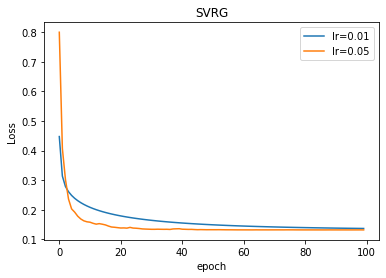

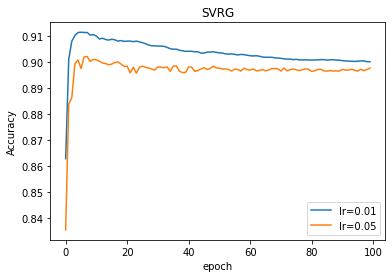

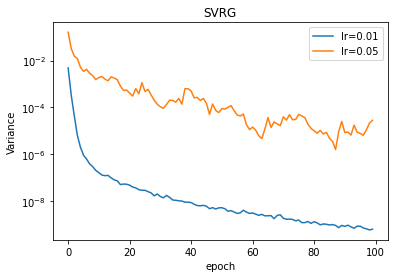

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()

M = 6000
m = 6000
n_iters = 100

labels = ['Loss', 'Accuracy', 'Variance']
Lambdas = [0.01, 0.05]
results = np.empty((2,3,n_iters))

obj = SVRG(torch.tensor(data), torch.tensor(test_data), m, n_iters)

evaluation_interval = m

for i in range(2):
  results[i] = obj.run(Lambdas[i])

SVRG_results1 = results[0,:,:]
SVRG_results2 = results[1,:,:]

print("Execution Time = " , time.time() - start_time)


for i in range(3):
  plt.title("SVRG")
  plt.ylabel(labels[i])
  plt.xlabel('epoch')

  if labels[i] == 'Variance':
    plt.yscale('log')

  for j in range(2):
    plt.plot(results[j][i] , label = 'lr=' + str(Lambdas[j]))
  plt.legend()
  plt.show()



Comparing results (for learning rates 0.01 , 0.05)


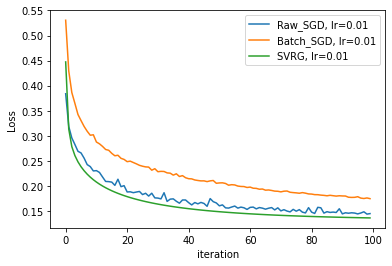

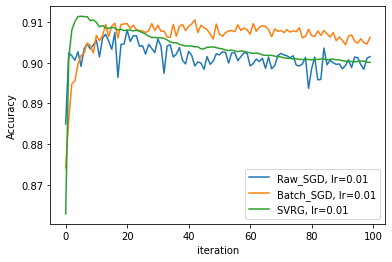

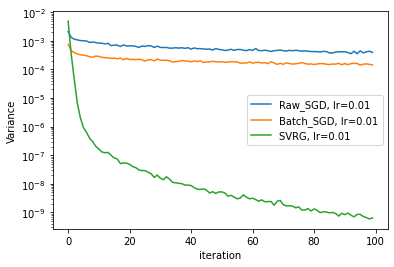

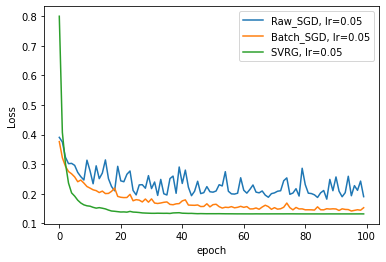

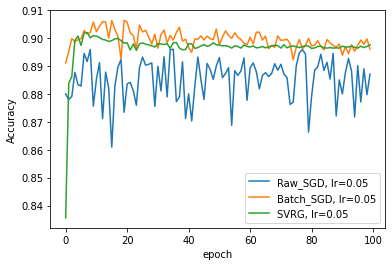

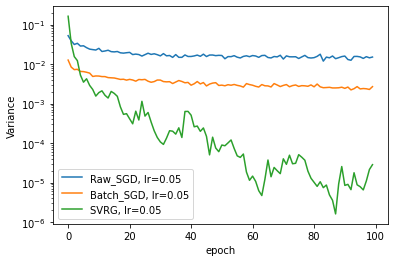

In [ ]:
labels = ['Loss', 'Accuracy', 'Variance']

#learning rate = 0.01
for i in range(3):
  plt.ylabel(labels[i])
  plt.xlabel('iteration')

  if labels[i] == 'Variance':
    plt.yscale('log')

  plt.plot(raw_SGD_results1[i] , label = 'Raw_SGD, lr=0.01')
  plt.plot(batch_SGD_results1[i] , label = 'Batch_SGD, lr=0.01')
  plt.plot(SVRG_results1[i] , label = 'SVRG, lr=0.01')
  plt.legend()
  plt.show()

#learning rate = 0.05
for i in range(3):
  plt.ylabel(labels[i])
  plt.xlabel('epoch')

  if labels[i] == 'Variance':
    plt.yscale('log')

  plt.plot(raw_SGD_results2[i] , label = 'Raw_SGD, lr=0.05')
  plt.plot(batch_SGD_results2[i] , label = 'Batch_SGD, lr=0.05')
  plt.plot(SVRG_results2[i] , label = 'SVRG, lr=0.05')
  plt.legend()
  plt.show()